<a href="https://colab.research.google.com/github/JoysGitHubPortfolio/RecommendationEngine-/blob/main/Joy_Cowper_Muzz_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ingestion

In [2]:
!ls drive/MyDrive/Muzz/

swipes.zip


In [3]:
!unzip drive/MyDrive/Muzz/swipes.zip -d swipes_data

Archive:  drive/MyDrive/Muzz/swipes.zip
  inflating: swipes_data/swipes.csv  


In [4]:
df = pd.read_csv("swipes_data/swipes.csv")
df.head()

,decidermemberid,othermemberid,timestamp,like,decidergender,othergender,deciderdobyear,otherdobyear,decidersignuptimestamp,othersignuptimestamp
0,3847776,3227524,2021-01-01 00:00:06,1,M,F,2002,1999,2020-12-28 11:19:02,2020-08-17 12:46:39
1,608590,519321,2021-01-01 00:00:06,0,F,M,1996,1992,2018-08-10 22:55:32,2018-06-17 15:34:37
2,397116,453914,2021-01-01 00:00:06,0,F,M,1991,1991,2018-03-04 22:14:06,2018-04-25 21:22:26
3,3847776,1269455,2021-01-01 00:00:06,1,M,F,2002,2000,2020-12-28 11:19:02,2019-04-22 20:02:54
4,1630969,347909,2021-01-01 00:00:23,0,F,M,1980,1983,2019-08-29 00:07:22,2018-01-17 12:14:03


In [5]:
len(df)

9859578

# Data Preparation

## Schema Statistics

In [24]:
df["like"].mean()

np.float64(0.3459173527415046)

In [14]:
unique_users = df[["decidermemberid", "decidergender"]].drop_duplicates().groupby("decidergender").size()
unique_users

,0
decidergender,
F,15159
M,36873


## Data Cleansing

In [6]:
ff_rows = len(df.loc[(df['decidergender'] == 'F') & (df['othergender'] == 'F')])
mm_rows = len(df.loc[(df['decidergender'] == 'M') & (df['othergender'] == 'M')])

print(ff_rows, mm_rows)

12556 19134


In [7]:
mask_valid = (
    (df["decidergender"] == "M") & (df["othergender"] == "F")
) | (
    (df["decidergender"] == "F") & (df["othergender"] == "M")
)

df = df[mask_valid].copy(deep=True)

In [92]:
like_rates = df.groupby(['decidergender', 'decidermemberid']).agg(num_swipes = ('like', 'size'),
                                                                  num_likes = ('like', 'sum'),
                                                                  like_rate = ('like', 'mean')).reset_index()

like_rates = like_rates[like_rates['like_rate'] > 0].copy(deep=True) # effectively filter out inactive users
like_rates = like_rates[like_rates['like_rate'] < 1].copy(deep=True) # effectively filter out spamming users

print('Number of Valid Users:', len(like_rates), '\n')
like_rates[0:5]

Number of Valid Users: 39556 



,decidergender,decidermemberid,num_swipes,num_likes,like_rate
2,F,1498,450,10,0.022222
3,F,1524,319,84,0.263323
4,F,1593,476,10,0.021008
5,F,1668,37,1,0.027027
6,F,1679,3,2,0.666667


In [93]:
def plot_my_member_dists(member_counts: pd.DataFrame = like_rates,
                         variable: str = 'num_swipes',
                         log: bool = False
                         ):

  fig, axes = plt.subplots(1, 2, figsize=(6, 2.5),
                           sharey=True,
                           constrained_layout=True)
  for ax, gender in zip(axes, ['M', 'F']):
      x = member_counts.loc[member_counts['decidergender'] == gender, variable]

      if log:
        x = np.log1p(x)
        log_title = 'log scale'
      else:
        log_title = ''

      if variable == 'num_swipes':
        ax.set_xlim(0,1000)
        bins=500
      if variable == 'num_likes':
        ax.set_xlim(0,250)
        bins=250
      if variable == 'like_rate':
        ax.set_xlim(0,1)
        bins=250

      ax.hist(x, bins=bins, density=True)
      x.plot(kind='kde',
            ax=ax,
            bw_method=0.25)

      ax.set_title(f'{gender} - Distribution:\n{log_title}')
      ax.set_xlabel(f'{variable}')
      ax.set_ylabel('Probability Density')

  plt.show()

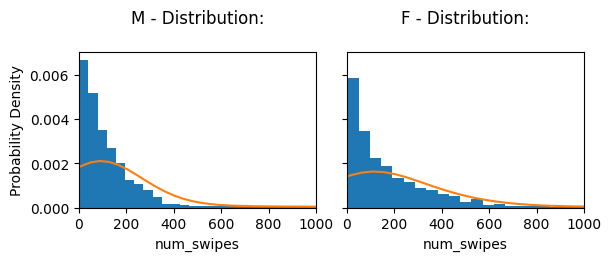

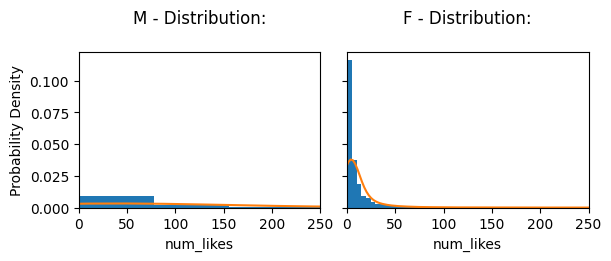

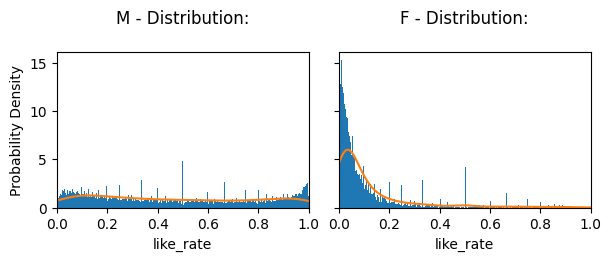

In [94]:
plot_my_member_dists(variable='num_swipes')
plot_my_member_dists(variable='num_likes')
plot_my_member_dists(variable='like_rate')

# Feature Engineering

In [85]:
# keep  deciders whose (gender, id) with non-0, non-spam likes
valid_deciders = like_rates[['decidergender', 'decidermemberid']]

df_filtered = df.merge(
    valid_deciders,
    on=['decidergender', 'decidermemberid'],
    how='inner'
).copy(deep=True)

df_filtered.shape

(9228495, 12)

In [87]:
# check filtered interactions df has only users that had valid like_rate
len(df_filtered['decidermemberid'].unique())

39556

In [53]:
# check retained users have like_rate between (0, 1)
check = (
    df_filtered
    .groupby(['decidergender', 'decidermemberid'])['like']
    .mean()
)

check.min(), check.max()

(0.00026232948583420777, 0.9998963945296312)

In [95]:
pairs = set(zip(df_filtered.decidermemberid, df_filtered.othermemberid))
df_filtered["reciprocal_possible"] = [
    (o, d) in pairs for d, o in zip(df_filtered.decidermemberid, df_filtered.othermemberid)
]

df_filtered.groupby("reciprocal_possible")["like"].mean()

,like
reciprocal_possible,
False,0.331027
True,0.476074
